# Imports & Settings

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                           confusion_matrix, classification_report, roc_curve, precision_recall_curve)
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier



plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def print_section(title, width = 80):
    print(f'\n{' = ' * width}')
    print(f'{title:^{width}}')
    print(f'{' = ' * width}\n')

def display_data_info(df, title = 'Dataset Information'):
    print_section(title)
    print(f'Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns')
    print(f'Memory usage: {df.memory_usage(deep = True).sum() / 1024**2:.2f} MB')
    print(f'Duplicate rows: {df.duplicated().sum():,}')
    
# Configuration

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUT_DIR = Path('/home/humpnduati/DATA_SCIENCE/25h--MachineLearing-1/Weekly Project/Week 3/credit_risk')
OUT_DIR.mkdir(parents = True, exist_ok = True)

DATA_PATH = '/home/humpnduati/DATA_SCIENCE/25h--MachineLearing-1/Weekly Project/Week 3/raw-data.csv'

# Ensemble configuration

SUBSET_RATIO = 0.20
N_SUBSETS = 10
FEATURE_SAMPLING_RATIO = 0.8
COST_FN = 5.0
COST_FP = 1.0

#  Data Loading & Initial Inspection

In [3]:
# Load data
print_section('DATA LOADING & INITIAL INSPECTION')

try:
    df = pd.read_csv(DATA_PATH)
    print(f' Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]:,} columns')
except FileNotFoundError:
    print(f' File not found: {DATA_PATH}')
    raise

# Initial data inspection

display_data_info(df, 'RAW DATA OVERVIEW')

# Display first few rows

print('\nFirst 5 rows:')
display(df.head())

print('\nData types:')
print(df.dtypes.value_counts())
print('\n' + '=' * 50)

# Check for basic structure

print(f'Missing values: {df.isnull().sum().sum():,}')
print(f'Columns with any missing values: {df.isnull().any().sum()}/{len(df.columns)}')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                       DATA LOADING & INITIAL INSPECTION                        
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

 Data loaded successfully: 119,528 rows × 32 columns

 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                               RAW DATA OVERVIEW                                
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,NaN,NaN,46500.0,NaN,NaN,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,NaN,NaN,28168.0,NaN,NaN,0,0,0,TIER 1,0
2,3,0,0,26.0,0.0,1707.0,38900.0,30.0,1346.0,SC,...,NaN,105000.0,38900.0,34.0,31.0,31,31,16,TIER 1,0
3,4,0,0,24.0,0.0,2128.0,42900.0,24.0,1375.0,SC,...,NaN,NaN,42900.0,NaN,NaN,0,0,0,TIER 1,0
4,5,0,0,27.0,0.0,1824.0,40900.0,30.0,4140.0,MC,...,NaN,NaN,40900.0,NaN,NaN,0,0,0,TIER 1,0



Data types:
float64    15
int64      11
object      6
Name: count, dtype: int64

Missing values: 987,539
Columns with any missing values: 20/32


#  Load data + validation 

In [4]:
print_section("STEP 1: LOAD DATA & RENAME")
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Upload dataset to {DATA_PATH}")

raw = pd.read_csv(DATA_PATH)
print("Raw shape:", raw.shape)

rename_map = {
    'V1': 'Customer_ID','V2': 'Bounced_First_EMI','V3': 'Bounces_12M','V4': 'Maximum_MOB',
    'V5': 'Bounced_While_Repaying','V6': 'EMI','V7': 'Loan_Amount','V8': 'Tenure',
    'V9': 'Dealer_Code','V10': 'Product_Code','V11': 'Advance_EMI_Paid','V12': 'Interest_Rate',
    'V13': 'Gender','V14': 'Employment_Type','V15': 'Resident_Type','V16': 'DOB',
    'V17': 'Age_At_Loan','V18': 'Loans_Count','V19': 'Secured_Loans','V20': 'Unsecured_Loans',
    'V21': 'Max_Sanctioned_Live','V22': 'New_Loans_3M','V23': 'Total_Secured_Amount_Live',
    'V24': 'Total_Unsecured_Amount_Live','V25': 'Max_TwoWheeler_Loan','V26': 'Months_Since_Last_PersonalLoan',
    'V27': 'Months_Since_First_ConsumerDurables','V28': 'Times_30DPD_6M','V29': 'Times_60DPD_6M',
    'V30': 'Times_90DPD_3M','V31': 'Tier','V32': 'Default'
}
df = raw.rename(columns = rename_map)
print("Columns after rename (sample):", df.columns[:32].tolist())

# auto-detect target if missing

if 'Default' not in df.columns:
    for c in df.columns:
        if set(pd.Series(df[c].dropna().unique())) <= {0,1}:
            df.rename(columns = {c:'Default'}, inplace = True)
            print(f"Auto-detected binary column '{c}' as Default")
            break
if 'Default' not in df.columns:
    raise ValueError("No binary target 'Default' found. Provide a binary target column.")

# Quick target check

print("Target counts:")
print(df['Default'].value_counts())


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                           STEP 1: LOAD DATA & RENAME                           
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Raw shape: (119528, 32)
Columns after rename (sample): ['Customer_ID', 'Bounced_First_EMI', 'Bounces_12M', 'Maximum_MOB', 'Bounced_While_Repaying', 'EMI', 'Loan_Amount', 'Tenure', 'Dealer_Code', 'Product_Code', 'Advance_EMI_Paid', 'Interest_Rate', 'Gender', 'Employment_Type', 'Resident_Type', 'DOB', 'Age_At_Loan', 'Loans_Count', 'Secured_Loans', 'Unsecured_Loans', 'Max_Sanctioned_Live', 'New_Loans_3M', 'Total_Secured_Amount_Live', 

# Data Cleaning

In [5]:
print_section('DATA CLEANING')

# Create a copy for cleaning

df_clean = df.copy()
print(' Created working copy for cleaning')

# Standard renames for expected variables

rename_map = {
    'V2': 'Bounced_First_EMI', 'V3': 'Bounces_12M', 'V6': 'EMI',
    'V7': 'Loan_Amount', 'V8': 'Tenure', 'V13': 'Gender', 'V17': 'Age_At_Loan',
    'V28': 'Times_30DPD_6M', 'V29': 'Times_60DPD_6M', 'V30': 'Times_90DPD_3M', 'V32': 'Default'
}

# Apply renames and keep only specified columns

df_clean = df_clean.rename(columns = rename_map)
columns_to_keep = [col for col in rename_map.values() if col in df_clean.columns]
df_clean = df_clean[columns_to_keep]

print(f' Applied standard renames. Keeping {len(columns_to_keep)} columns:')
for i, col in enumerate(columns_to_keep, 1):
    print(f'   {i:2d}. {col}')

# Target variable validation

if 'Default' not in df_clean.columns:

    # Auto-detect binary target

    binary_cols = []
    for col in df_clean.columns:
        unique_vals = df_clean[col].dropna().unique()
        if set(unique_vals) <= {0, 1} and len(unique_vals) == 2:
            binary_cols.append(col)
    
    if binary_cols:
        df_clean = df_clean.rename(columns = {binary_cols[0]: 'Default'})
        print(f" Auto-detected target: '{binary_cols[0]}' → 'Default'")
    else:
        raise ValueError('No suitable binary target column found')
else:
    
    # Validate target variable
    
    target_unique = df_clean['Default'].dropna().unique()
    if not set(target_unique) <= {0, 1}:
        print(f'Target has non-binary values: {target_unique}')
        
        # Convert to binary if possible
        
        if len(target_unique) == 2:
            le = LabelEncoder()
            df_clean['Default'] = le.fit_transform(df_clean['Default'])
            print(f' Encoded target to binary: {le.classes_}')

print(f'Target distribution: {df_clean['Default'].value_counts().to_dict()}')

# Handle critical missing values

critical_columns = ['Loan_Amount', 'Gender', 'Default']
available_critical = [col for col in critical_columns if col in df_clean.columns]

initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset = available_critical)
rows_removed = initial_rows - len(df_clean)
print(f'Removed {rows_removed:,} rows with missing critical columns')

# Remove duplicate rows

initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
duplicates_removed = initial_rows - len(df_clean)
print(f'Removed {duplicates_removed:,} duplicate rows')

display_data_info(df_clean, 'AFTER CLEANING')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                                 DATA CLEANING                                  
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

 Created working copy for cleaning
 Applied standard renames. Keeping 11 columns:
    1. Bounced_First_EMI
    2. Bounces_12M
    3. EMI
    4. Loan_Amount
    5. Tenure
    6. Gender
    7. Age_At_Loan
    8. Times_30DPD_6M
    9. Times_60DPD_6M
   10. Times_90DPD_3M
   11. Default
Target distribution: {0: 116914, 1: 2614}
Removed 34,480 rows with missing critical columns
Removed 5,521 duplicate rows

 =  =  =  =  =  =  =  =  =  =

# Comprehensive EDA: Univariate Analysis


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                     EXPLORATORY DATA ANALYSIS - UNIVARIATE                     
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Analyzing 9 numeric and 1 categorical features


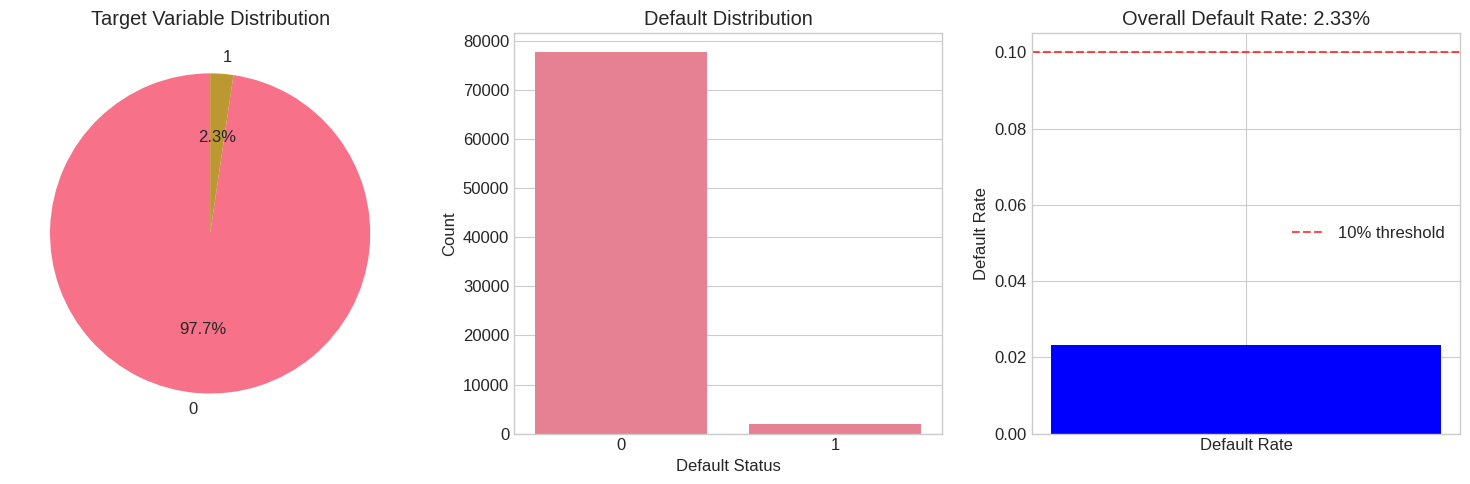

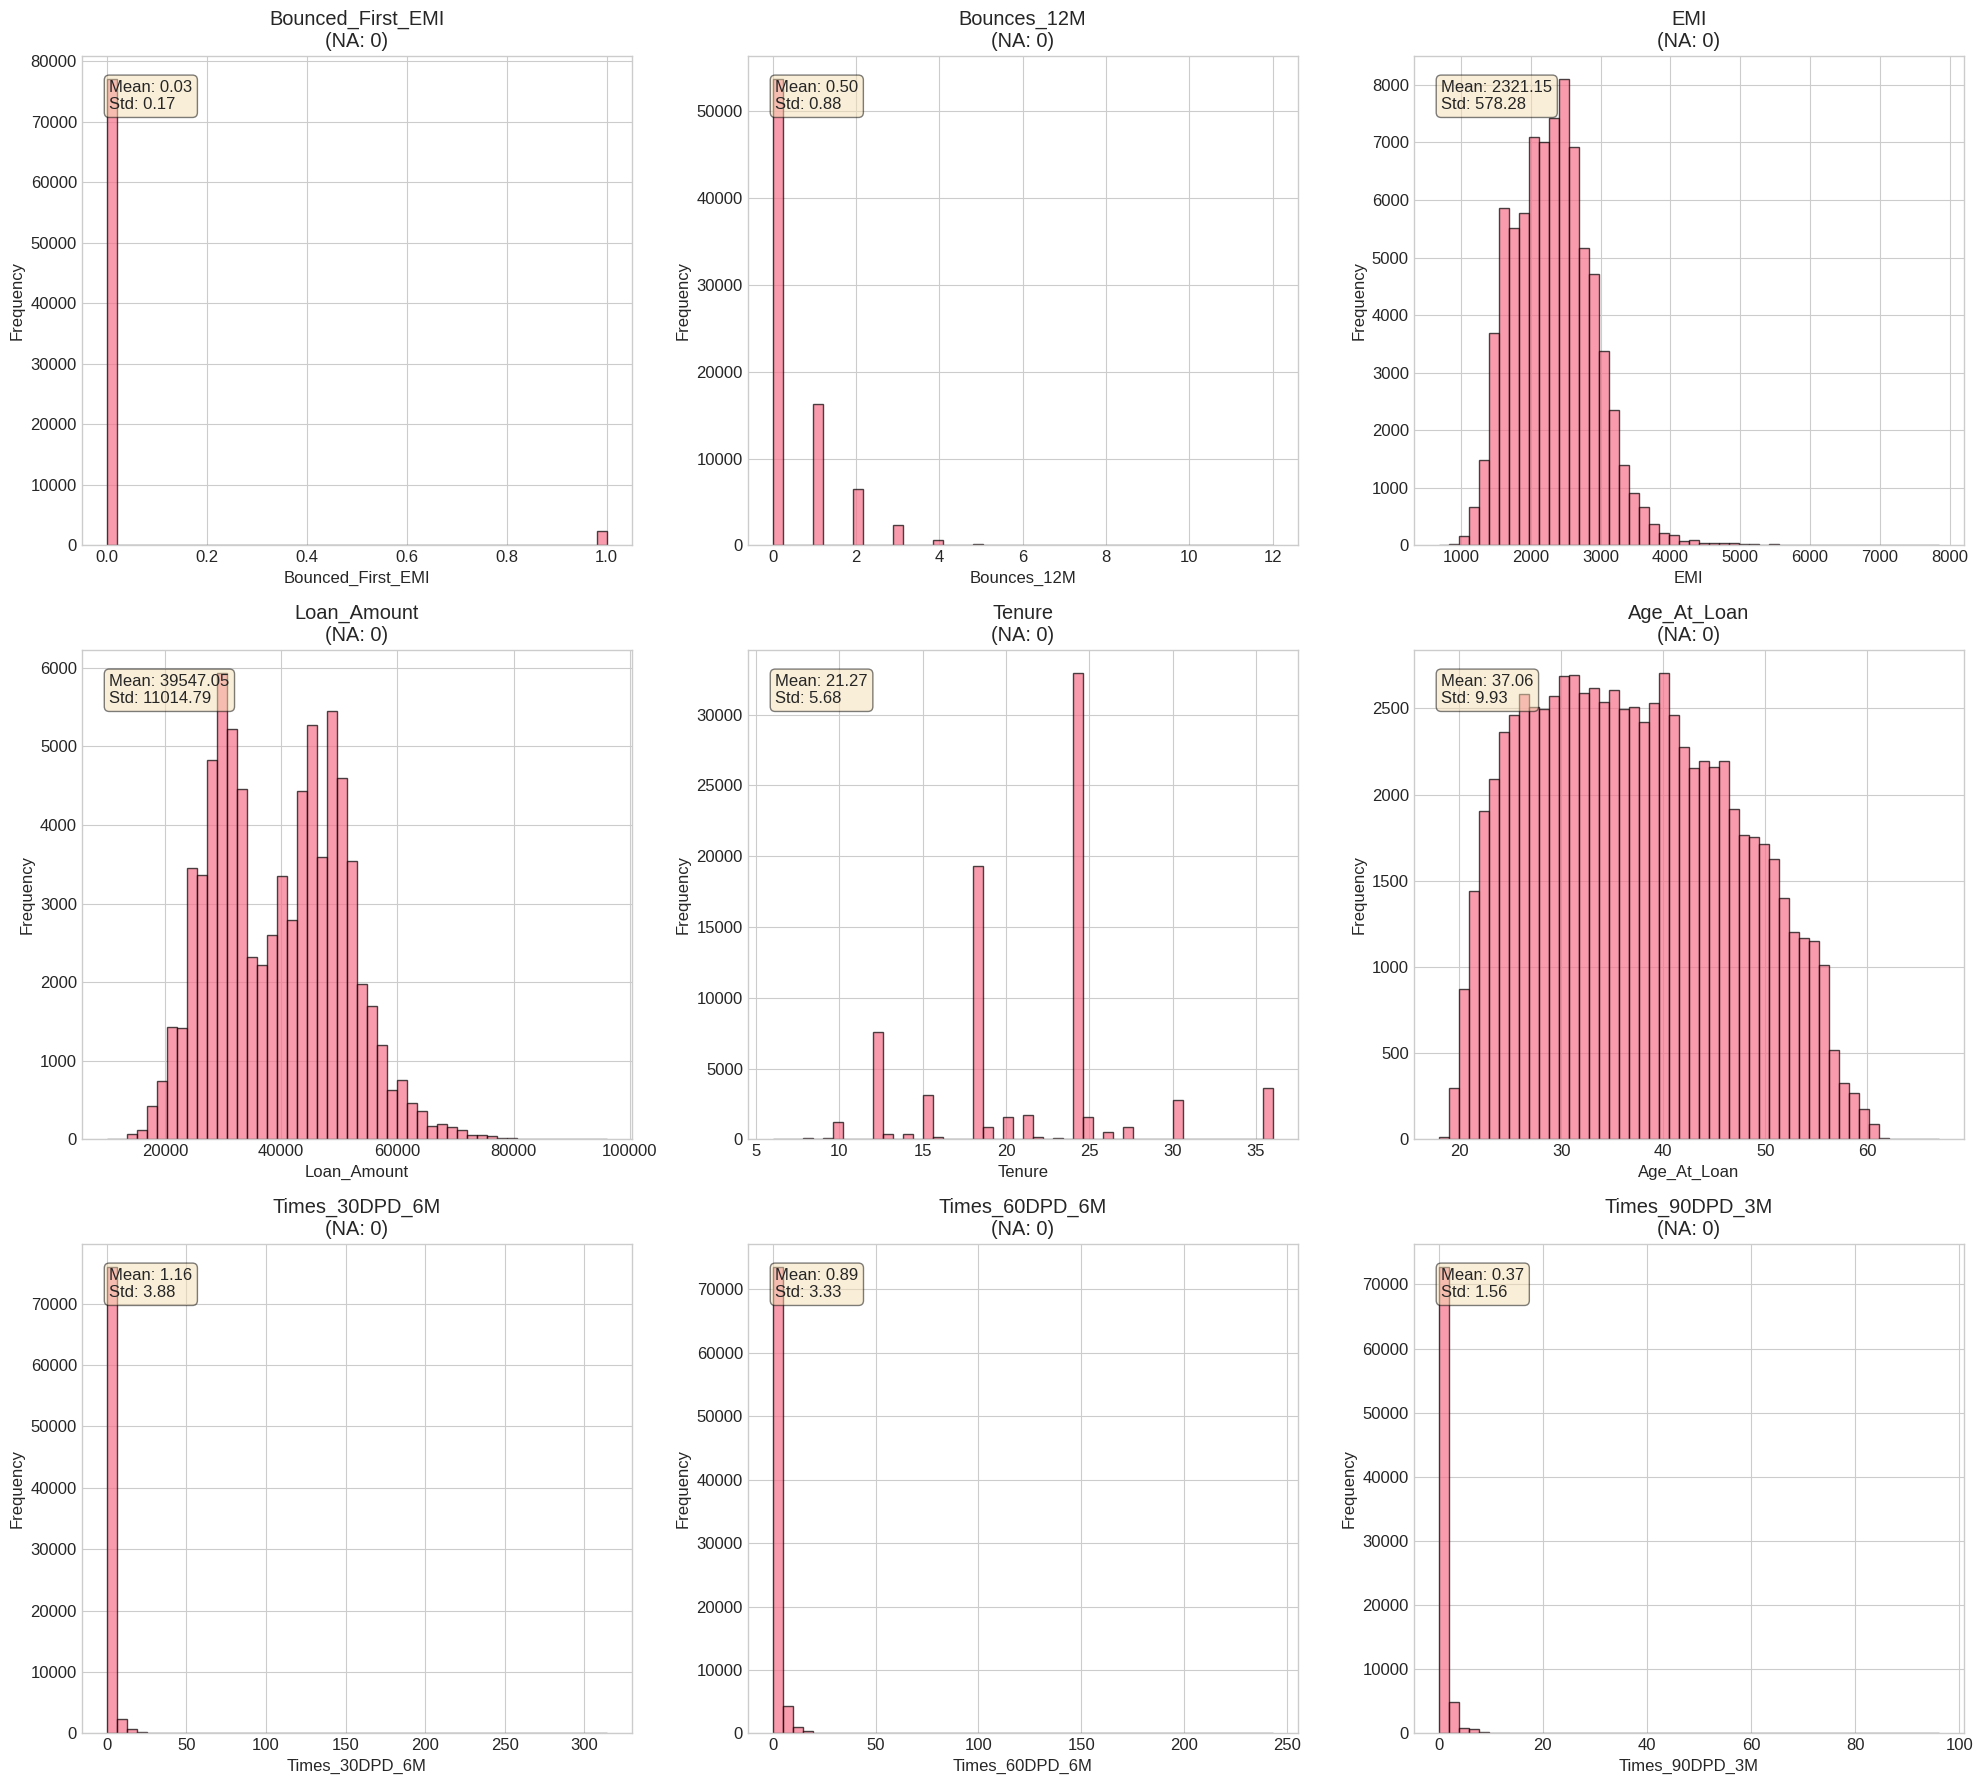

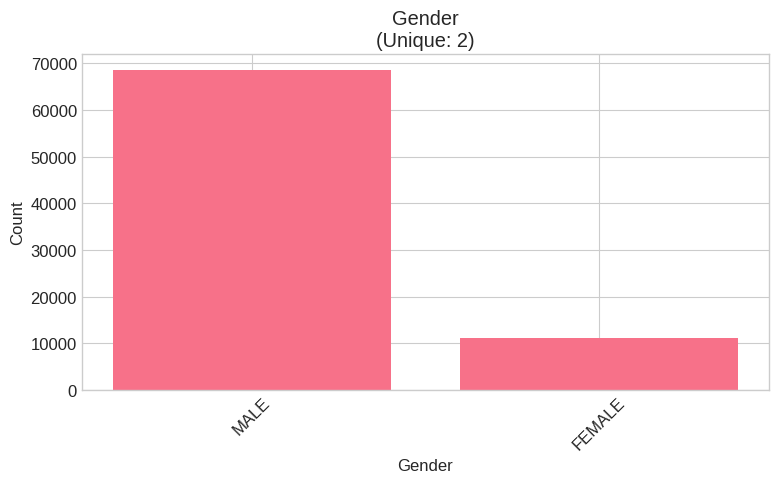

In [6]:
print_section("EXPLORATORY DATA ANALYSIS - UNIVARIATE")

# Create EDA directory

eda_dir = OUT_DIR / 'eda_plots'
eda_dir.mkdir(exist_ok = True)

def plot_univariate_analysis(df, target_col='Default'):
    """Comprehensive univariate analysis"""
    
    # Separate numeric and categorical features
    
    numeric_cols = df.select_dtypes(include = [np.number]).columns.drop(target_col, errors = 'ignore')
    categorical_cols = df.select_dtypes(include = ['object', 'category']).columns
    
    print(f'Analyzing {len(numeric_cols)} numeric and {len(categorical_cols)} categorical features')
    
    # 1. Target distribution
    
    plt.figure(figsize = (15, 5))
    
    plt.subplot(1, 3, 1)
    target_counts = df[target_col].value_counts()
    plt.pie(target_counts.values, labels = target_counts.index, autopct = '%1.1f%%', startangle = 90)
    plt.title('Target Variable Distribution')
    
    plt.subplot(1, 3, 2)
    sns.countplot(data = df, x = target_col)
    plt.title('Default Distribution')
    plt.xlabel('Default Status')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 3)
    default_rate = df[target_col].mean()
    plt.bar(['Default Rate'], [default_rate], color = 'red' if default_rate > 0.1 else 'blue')
    plt.axhline(y = 0.1, color = 'r', linestyle = '--', alpha = 0.7, label = '10% threshold')
    plt.ylabel('Default Rate')
    plt.title(f'Overall Default Rate: {default_rate:.2%}')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(eda_dir / 'target_distribution.png', dpi = 300, bbox_inches = 'tight')
    plt.show()
    
    # 2. Numeric features distribution
    
    if len(numeric_cols) > 0:
        n_numeric = len(numeric_cols)
        n_cols = 3
        n_rows = (n_numeric + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 6*n_rows))
        axes = axes.flatten() if n_numeric > 1 else [axes]
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):

                # Handle infinite values
                
                col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(col_data) > 0:
                    axes[i].hist(col_data, bins = 50, alpha = 0.7, edgecolor = 'black')
                    axes[i].set_title(f'{col}\n(NA: {df[col].isna().sum():,})')
                    axes[i].set_xlabel(col)
                    axes[i].set_ylabel('Frequency')
                    
                    # Add statistics

                    stats_text = f'Mean: {col_data.mean():.2f}\nStd: {col_data.std():.2f}'
                    axes[i].text(0.05, 0.95, stats_text, transform = axes[i].transAxes, 
                               verticalalignment = 'top', bbox = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.5))
        
        # Remove empty subplots

        for i in range(len(numeric_cols), len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.savefig(eda_dir / 'numeric_distributions.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
    
    # 3. Categorical features distribution

    if len(categorical_cols) > 0:
        n_categorical = len(categorical_cols)
        n_cols = 2
        n_rows = (n_categorical + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 5 * n_rows))
        
        # Always flatten axes to a list for consistent indexing
        
        if isinstance(axes, np.ndarray):
            axes = axes.flatten()
        else:
            axes = [axes]
        
        for i, col in enumerate(categorical_cols):
            if i < len(axes):
                top_categories = df[col].value_counts().head(10)
                axes[i].bar(range(len(top_categories)), top_categories.values)
                axes[i].set_title(f'{col}\n(Unique: {df[col].nunique()})')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Count')
                axes[i].set_xticks(range(len(top_categories)))
                axes[i].set_xticklabels(top_categories.index, rotation = 45)
        
        # Remove empty subplots

        for i in range(len(categorical_cols), len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.savefig(eda_dir / 'categorical_distributions.png', dpi = 300, bbox_inches = 'tight')
        plt.show()

# Perform univariate analysis

plot_univariate_analysis(df_clean)


# Comprehensive EDA: Bivariate Analysis


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                     EXPLORATORY DATA ANALYSIS - BIVARIATE                      
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 



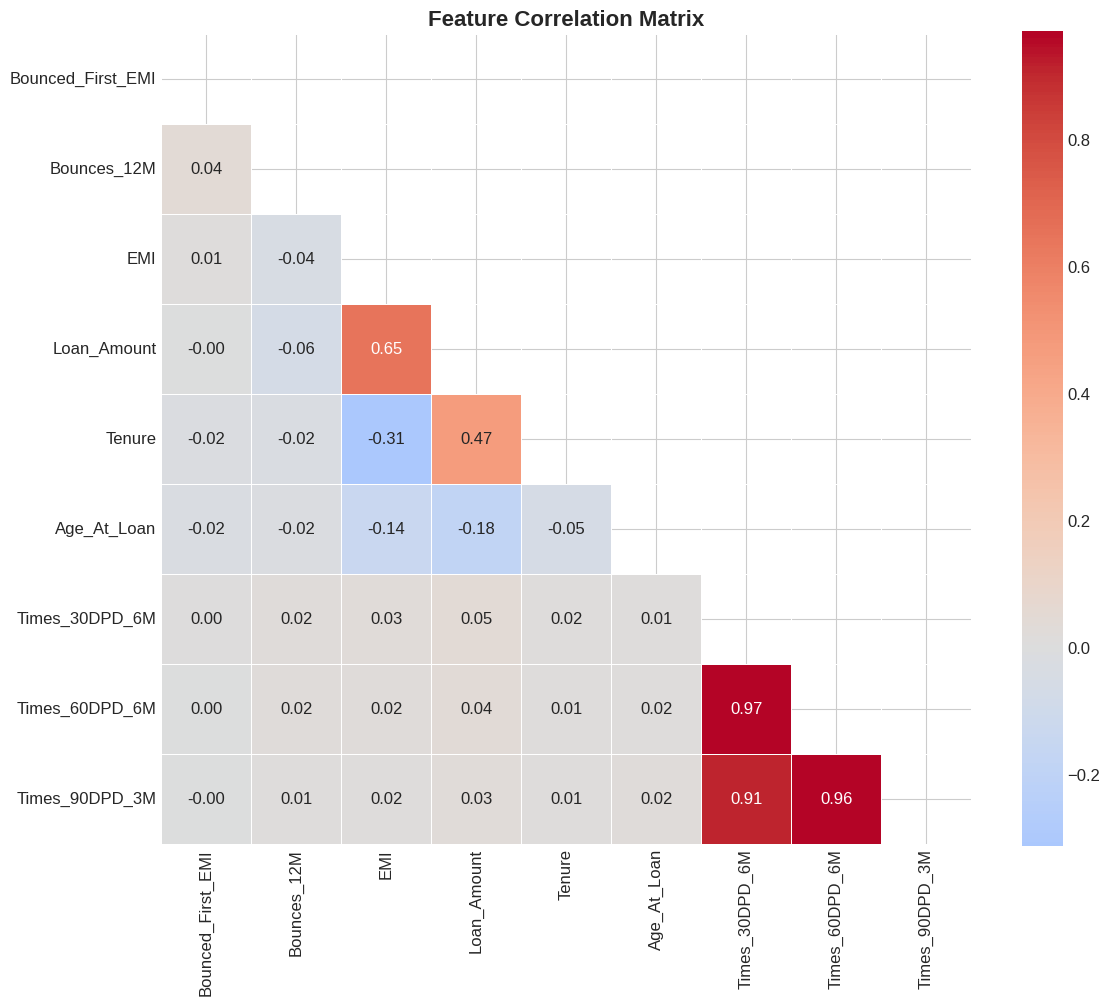

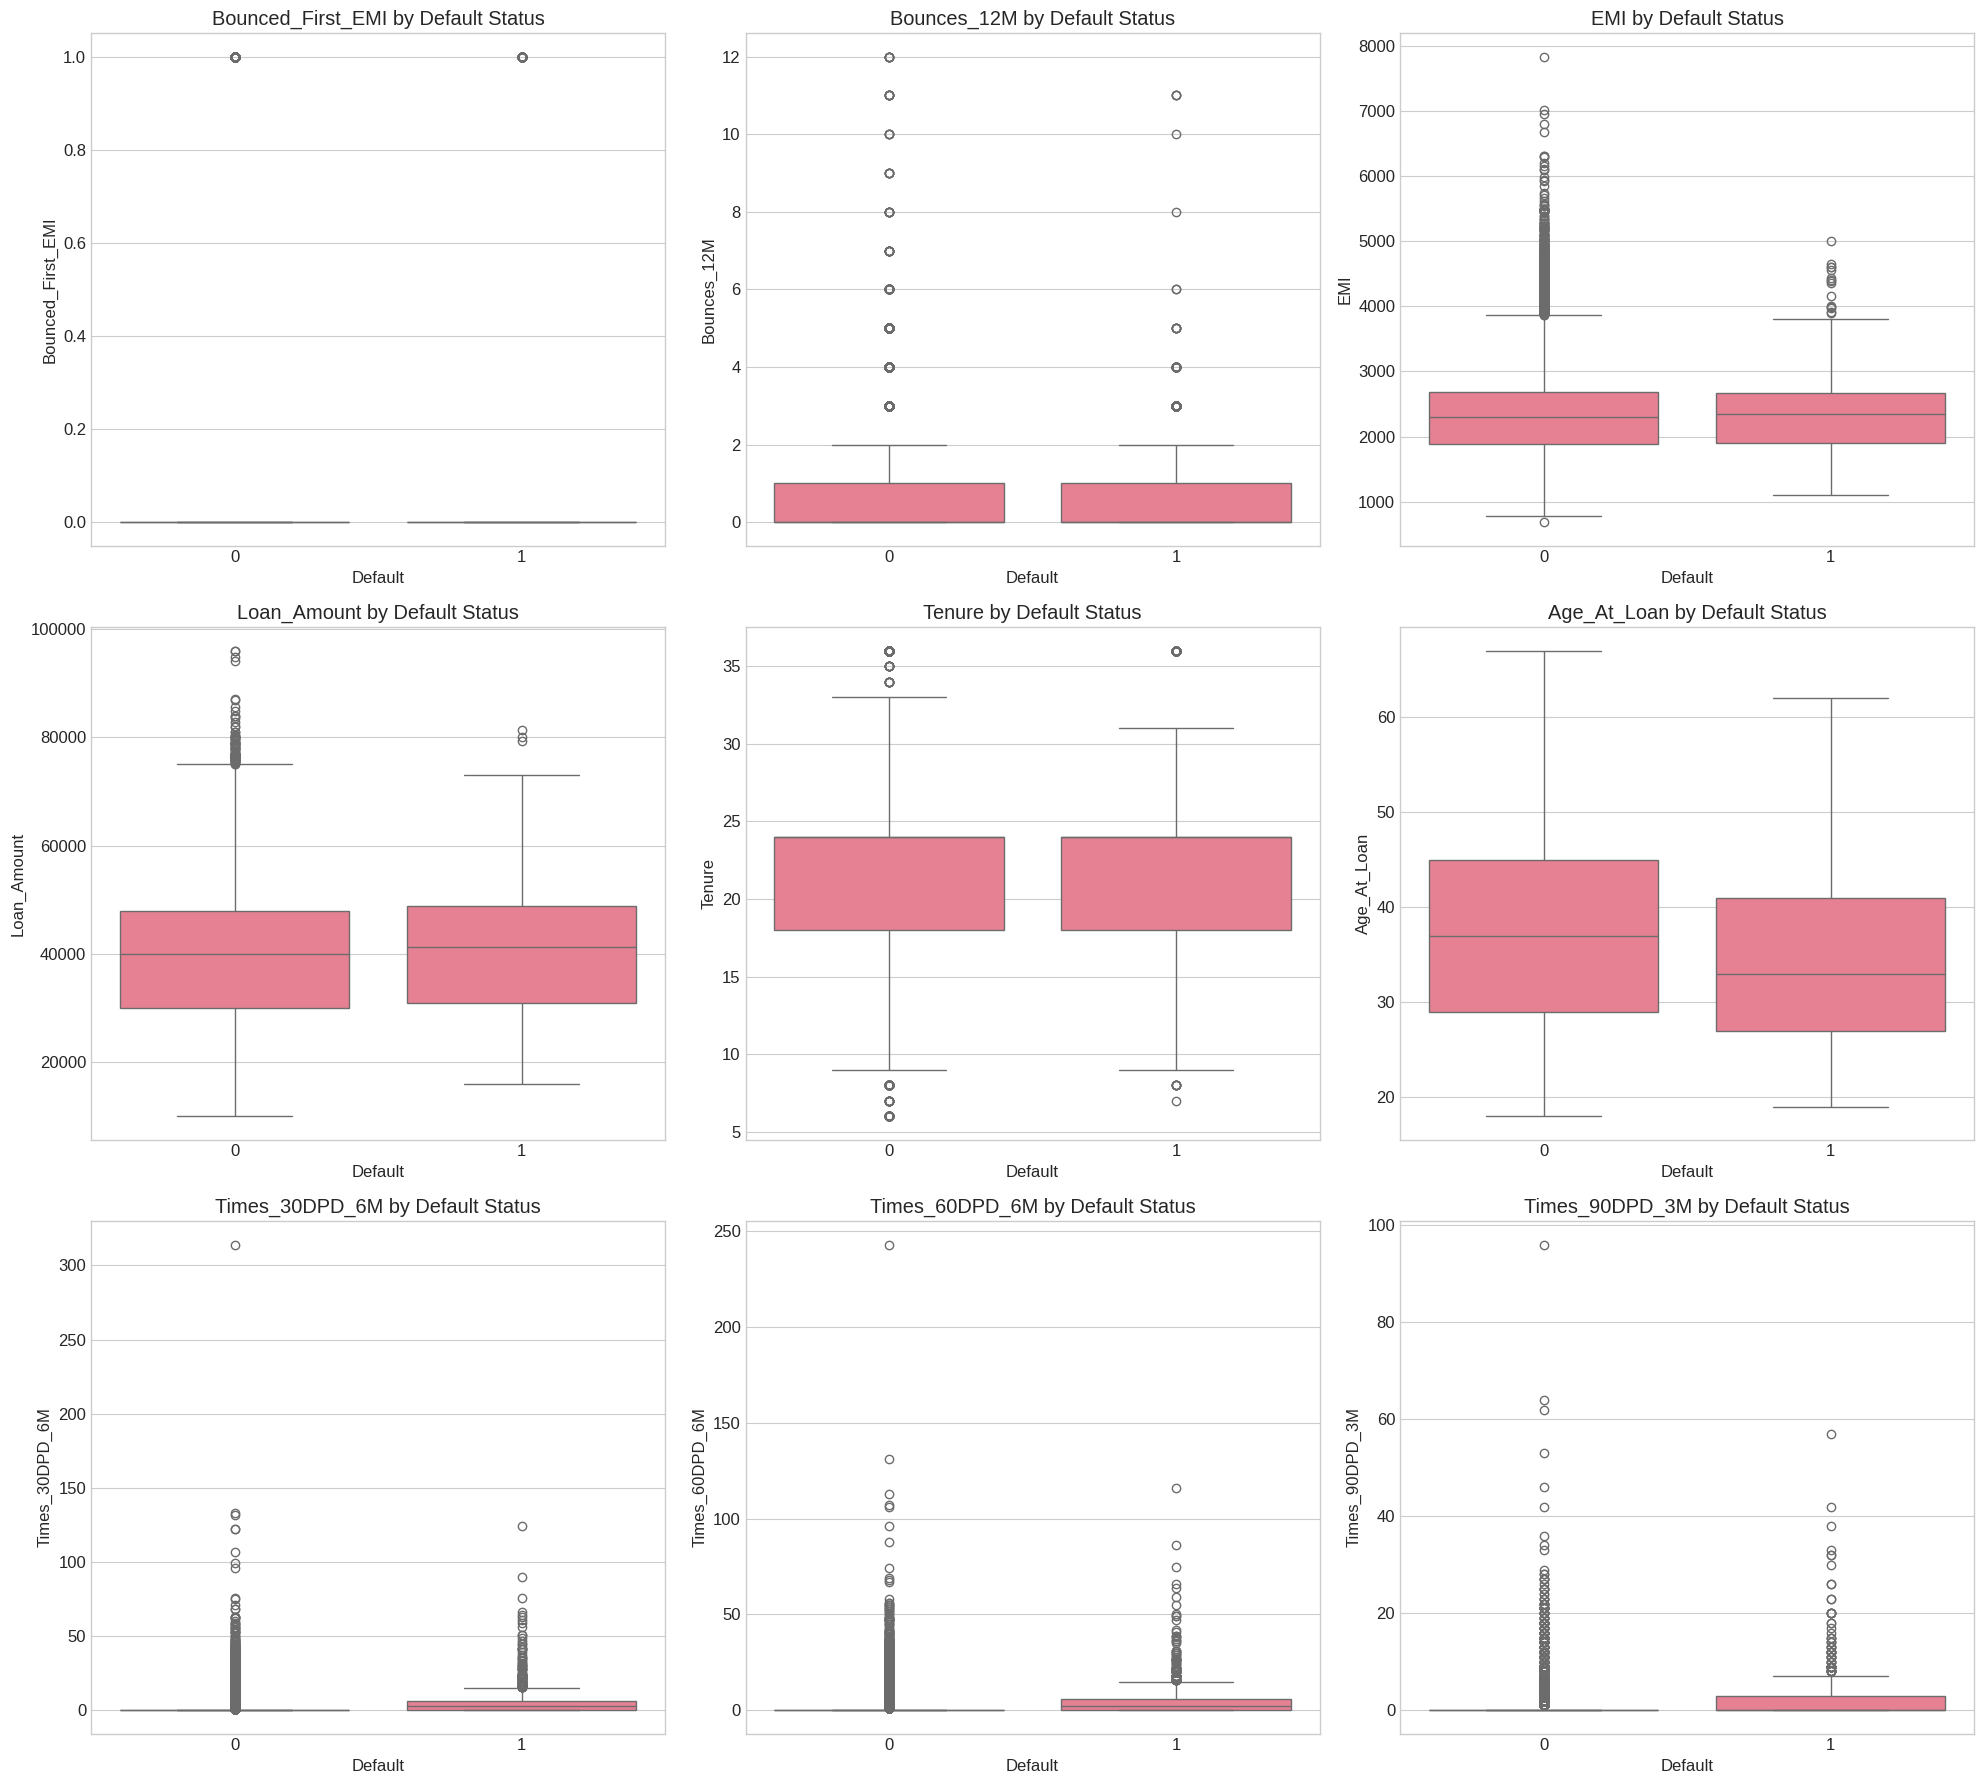

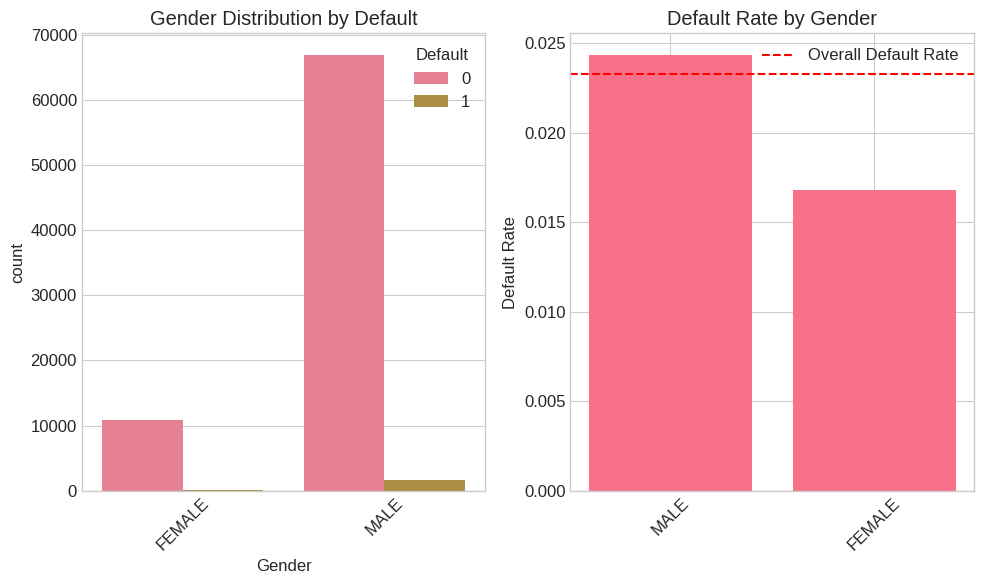

In [7]:
print_section('EXPLORATORY DATA ANALYSIS - BIVARIATE')

def plot_bivariate_analysis(df, target_col = 'Default'):
    """Comprehensive bivariate analysis with target"""
    
    numeric_cols = df.select_dtypes(include = [np.number]).columns.drop(target_col, errors = 'ignore')
    categorical_cols = df.select_dtypes(include = ['object', 'category']).columns
    
    # 1. Correlation matrix for numeric features
    
    if len(numeric_cols) > 0:
        plt.figure(figsize = (12, 10))
        
        # Calculate correlation matrix

        corr_matrix = df[numeric_cols].corr()
        
        # Create mask for upper triangle
        
        mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
        
        # Plot heatmap
        
        sns.heatmap(corr_matrix, mask = mask, annot = True, fmt = '.2f', cmap = 'coolwarm', 
                   center = 0, square = True, linewidths = 0.5)
        plt.title('Feature Correlation Matrix', fontsize = 16, fontweight = 'bold')
        plt.tight_layout()
        plt.savefig(eda_dir / 'correlation_matrix.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        # Display top correlations with target

        if target_col in numeric_cols:
            target_correlations = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
            print('Top correlations with target:')
            for feature, corr in target_correlations.head(10).items():
                print(f'  {feature:20} : {corr:+.3f}')
    
    # 2. Numeric features vs target
    
    if len(numeric_cols) > 0 and target_col in df.columns:
        n_numeric = len(numeric_cols)
        n_cols = 3
        n_rows = (n_numeric + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 6 * n_rows))
        axes = axes.flatten() if n_numeric > 1 else [axes]
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                
                # Boxplot by target

                df_box = df[[col, target_col]].dropna()
                sns.boxplot(data = df_box, x = target_col, y = col, ax = axes[i])
                axes[i].set_title(f'{col} by Default Status')
                axes[i].set_xlabel('Default')
                axes[i].set_ylabel(col)
        
        # Remove empty subplots

        for i in range(len(numeric_cols), len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.savefig(eda_dir / 'numeric_vs_target.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
    
    # 3. Categorical features vs target

    if len(categorical_cols) > 0 and target_col in df.columns:
        for col in categorical_cols:
            if df[col].nunique() <= 10:  # Only plot for reasonable number of categories
                plt.figure(figsize = (10, 6))

                # Calculate default rates by category
                
                category_stats = df.groupby(col)[target_col].agg(['count', 'mean']).sort_values('mean', ascending = False)
                category_stats = category_stats[category_stats['count'] > 10]  # Filter small categories
                
                # Plot

                plt.subplot(1, 2, 1)
                sns.countplot(data = df, x = col, hue = target_col)
                plt.title(f'{col} Distribution by Default')
                plt.xticks(rotation = 45)
                
                plt.subplot(1, 2, 2)
                plt.bar(range(len(category_stats)), category_stats['mean'])
                plt.axhline(y = df[target_col].mean(), color = 'r', linestyle = '--', label = 'Overall Default Rate')
                plt.title(f'Default Rate by {col}')
                plt.xticks(range(len(category_stats)), category_stats.index, rotation = 45)
                plt.ylabel('Default Rate')
                plt.legend()
                
                plt.tight_layout()
                plt.savefig(eda_dir / f'categorical_{col}_vs_target.png', dpi = 300, bbox_inches = 'tight')
                plt.show()

# Perform bivariate analysis

plot_bivariate_analysis(df_clean)


# Comprehensive EDA: Multivariate & Advanced Analysis


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                    EXPLORATORY DATA ANALYSIS - MULTIVARIATE                    
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 



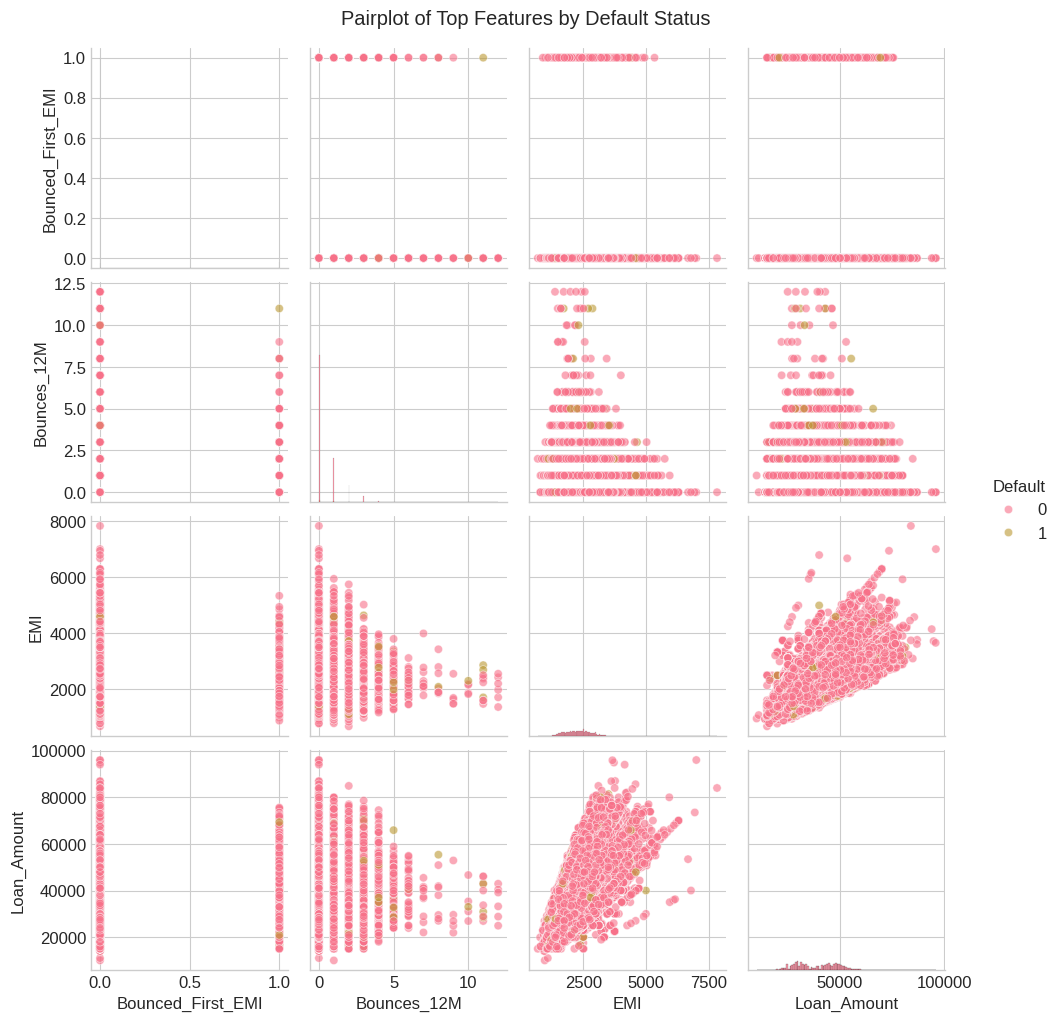

In [8]:
print_section('EXPLORATORY DATA ANALYSIS - MULTIVARIATE')

def plot_multivariate_analysis(df, target_col = 'Default'):
    """Advanced multivariate analysis"""

    numeric_cols = df.select_dtypes(include = [np.number]).columns.drop(target_col, errors = 'ignore')

    if len(numeric_cols) >= 2 and target_col in df.columns:
        
        # 1. Pairplot for top correlated features

        top_features = numeric_cols[:4]  # Limit to top 4 for readability
        if len(top_features) >= 2:
            pairplot_data = df[list(top_features) + [target_col]].dropna()
            g = sns.pairplot(pairplot_data, hue = target_col, diag_kind = 'hist', 
                           plot_kws = {'alpha': 0.6}, diag_kws = {'alpha': 0.7})
            g.fig.suptitle('Pairplot of Top Features by Default Status', y = 1.02)
            plt.savefig(eda_dir / 'feature_pairplot.png', dpi = 300, bbox_inches = 'tight')
            plt.show()
        
        # 2. Feature importance preview (correlation with target)
        
        if target_col in numeric_cols:
            correlations = df[numeric_cols].corr()[target_col].abs().sort_values(ascending = False)
            correlations = correlations[correlations.index != target_col]            
            plt.figure(figsize = (10, 6))
            correlations.head(10).plot(kind = 'barh')
            plt.title('Top 10 Features by Absolute Correlation with Target')
            plt.xlabel('Absolute Correlation')
            plt.tight_layout()
            plt.savefig(eda_dir / 'feature_importance_correlation.png', dpi = 300, bbox_inches = 'tight')
            plt.show()
    
    # 3. Missing values analysis
    
    missing_analysis = df.isnull().sum()
    missing_analysis = missing_analysis[missing_analysis > 0].sort_values(ascending = False)

    if len(missing_analysis) > 0:
        plt.figure(figsize = (10, 6))
        missing_analysis.plot(kind = 'barh')
        plt.title('Missing Values by Feature')
        plt.xlabel('Number of Missing Values')
        plt.tight_layout()
        plt.savefig(eda_dir / 'missing_values_analysis.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        print('Missing values summary:')
        for col, missing_count in missing_analysis.items():
            missing_pct = (missing_count / len(df)) * 100
            print(f'  {col:20} : {missing_count:6,} ({missing_pct:5.1f}%)')

# Perform multivariate analysis

plot_multivariate_analysis(df_clean)

#  Advanced Feature Engineering

In [9]:
print_section('ADVANCED FEATURE ENGINEERING')

def create_advanced_features(df):
    """Create sophisticated features for credit risk modeling"""
    
    df_eng = df.copy()
    features_created = []
    
    # 1. Payment behavior features
    
    due_cols = [c for c in ['Times_30DPD_6M', 'Times_60DPD_6M', 'Times_90DPD_3M'] if c in df_eng.columns]
    if due_cols:
    
        # Weighted delinquency score
    
        weights = {'Times_30DPD_6M': 1, 'Times_60DPD_6M': 3, 'Times_90DPD_3M': 5}
        df_eng['Delinquency_Score'] = sum(df_eng[c] * weights.get(c, 1) for c in due_cols)
        features_created.append('Delinquency_Score')
        
        # Any delinquency flag
    
        df_eng['Any_Delinquency'] = (df_eng[due_cols].sum(axis = 1) > 0).astype(int)
        features_created.append('Any_Delinquency')
        
        # Severe delinquency flag

        severe_cols = [c for c in due_cols if '60' in c or '90' in c]
        if severe_cols:
            df_eng['Severe_Delinquency'] = (df_eng[severe_cols].sum(axis = 1) > 0).astype(int)
            features_created.append('Severe_Delinquency')
    
    # 2. Loan utilization features

    if {'EMI', 'Loan_Amount'}.issubset(df_eng.columns):
        df_eng['EMI_to_Loan_Ratio'] = df_eng['EMI'] / (df_eng['Loan_Amount'] + 1)
        features_created.append('EMI_to_Loan_Ratio')
        
        # EMI affordability (assuming monthly income estimation)
    
        df_eng['EMI_Affordability'] = df_eng['EMI'] / (df_eng['Loan_Amount'] / df_eng.get('Tenure', 12) + 1)
        features_created.append('EMI_Affordability')
    
    # 3. Bounce behavior features
    
    if {'Bounces_12M', 'Tenure'}.issubset(df_eng.columns):
        df_eng['Bounce_Rate'] = df_eng['Bounces_12M'] / (df_eng['Tenure'] + 1)
        features_created.append('Bounce_Rate')
        
        df_eng['Bounced_First_EMI_Flag'] = (df_eng.get('Bounced_First_EMI', 0) > 0).astype(int)
        features_created.append('Bounced_First_EMI_Flag')
    
    # 4. Age-based features
    
    if 'Age_At_Loan' in df_eng.columns:
        df_eng['Age_Bucket'] = pd.cut(df_eng['Age_At_Loan'], 
                                    bins = [18, 25, 35, 45, 55, 100], 
                                    labels = ['18-25', '26-35', '36-45', '46-55', '55+'])
        features_created.append('Age_Bucket')
        
        # Young borrower flag (higher risk)

        df_eng['Young_Borrower'] = (df_eng['Age_At_Loan'] < 25).astype(int)
        features_created.append('Young_Borrower')
    
    # 5. Interaction features
    
    if {'Bounces_12M', 'Times_30DPD_6M'}.issubset(df_eng.columns):
        df_eng['Bounce_Delinquency_Interaction'] = df_eng['Bounces_12M'] * df_eng['Times_30DPD_6M']
        features_created.append('Bounce_Delinquency_Interaction')
    
    print(f'Created {len(features_created)} advanced features:')
    for i, feature in enumerate(features_created, 1):
        print(f'   {i:2d}. {feature}')
    
    return df_eng, features_created

# Apply advanced feature engineering

df_final, new_features = create_advanced_features(df_clean)

print(f'\n Final dataset shape: {df_final.shape}')
print(f'Target variable: Default')
print(f'Features available: {df_final.shape[1] - 1}')

# Display feature summary

numeric_features = df_final.select_dtypes(include = [np.number]).columns.drop('Default', errors = 'ignore')
categorical_features = df_final.select_dtypes(include = ['object', 'category']).columns

print(f'\nFeature breakdown:')
print(f'  Numeric features: {len(numeric_features)}')
print(f' Categorical features: {len(categorical_features)}')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                          ADVANCED FEATURE ENGINEERING                          
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Created 10 advanced features:
    1. Delinquency_Score
    2. Any_Delinquency
    3. Severe_Delinquency
    4. EMI_to_Loan_Ratio
    5. EMI_Affordability
    6. Bounce_Rate
    7. Bounced_First_EMI_Flag
    8. Age_Bucket
    9. Young_Borrower
   10. Bounce_Delinquency_Interaction

 Final dataset shape: (79527, 21)
Target variable: Default
Features available: 20

Feature breakdown:
  Numeric features: 18
 Categorical features: 2


In [10]:
# Data Preprocessing Pipeline

In [11]:
print_section('DATA PREPROCESSING')

# Prepare features and target

id_col = 'Customer_ID' if 'Customer_ID' in df_final.columns else None
X = df_final.drop(columns = ['Default'] + ([id_col] if id_col else []), errors = 'ignore')
y = df_final['Default'].astype(int)

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

# Data quality report

print('\n DATA QUALITY REPORT:')
print(f'Total samples: {len(X):,}')
print(f'Default rate: {y.mean():.2%}')
print(f'Features: {X.shape[1]}')
print(f'Missing values: {X.isnull().sum().sum():,}')

# Split data strategically

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    stratify = y, 
    random_state = RANDOM_STATE
)

print(f'\nData split completed:')
print(f' Training set: {X_train.shape[0]:,} samples')
print(f'   Test set: {X_test.shape[0]:,} samples')
print(f'   Training default rate: {y_train.mean():.2%}')
print(f'   Test default rate: {y_test.mean():.2%}')

# Create flexible preprocessing function

def create_preprocessor_for_subset(num_cols, cat_cols):
    """Create a preprocessing pipeline"""
    
    transformers = []
    
    if num_cols:
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy = 'median')),
            ('scaler', RobustScaler())
        ])
        transformers.append(('num', num_pipeline, num_cols))
    
    if cat_cols:
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse_output = True, drop = 'first'))
        ])
        transformers.append(('cat', cat_pipeline, cat_cols))
    
    preprocessor = ColumnTransformer(
        transformers = transformers,
        remainder = 'drop',
        n_jobs = -1
    )
    
    return preprocessor

print('Preprocessing pipeline defined')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                               DATA PREPROCESSING                               
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Features shape: (79527, 20)
Target shape: (79527,)

 DATA QUALITY REPORT:
Total samples: 79,527
Default rate: 2.33%
Features: 20
Missing values: 14

Data split completed:
 Training set: 63,621 samples
   Test set: 15,906 samples
   Training default rate: 2.33%
   Test default rate: 2.33%
Preprocessing pipeline defined


# 20% Subset Ensemble Strategy Implementation

In [12]:
print_section('20% SUBSET ENSEMBLE STRATEGY IMPLEMENTATION')

def create_diverse_20pct_subsets(X, y, n_subsets = 10, subset_ratio = 0.2, feature_sampling_ratio = 0.8):
    """Create highly diverse 20% subsets with maximum feature diversity"""
    
    subsets = []
    n_samples = int(len(X) * subset_ratio)
    
    print(f'Creating {n_subsets} subsets with {n_samples:,} samples each ({subset_ratio:.0%} of data)')
    print(f'Feature sampling: {feature_sampling_ratio:.0%} of features per subset')
    
    for i in range(n_subsets):
        seed = RANDOM_STATE + i * 1000
        
        # Feature sampling for diversity
        
        n_features = max(1, int(X.shape[1] * feature_sampling_ratio))
        feature_indices = np.random.RandomState(seed).choice(
            X.shape[1], size = n_features, replace = False
        )
        feature_names = X.columns[feature_indices].tolist()
        
        # Stratified sampling
        
        unique_classes = y.unique()
        indices = []
        
        for cls in unique_classes:
            cls_indices = y[y == cls].index
            n_class_samples = max(1, int(n_samples * (len(cls_indices) / len(X))))
            cls_selected = np.random.RandomState(seed).choice(
                cls_indices, size = min(n_class_samples, len(cls_indices)), replace = False
            )
            indices.extend(cls_selected)
        
        # Fill remaining slots
        
        if len(indices) < n_samples:
            remaining = n_samples - len(indices)
            all_indices = set(X.index)
            used_indices = set(indices)
            available_indices = list(all_indices - used_indices)
            if available_indices:
                additional = np.random.RandomState(seed).choice(
                    available_indices, size = min(remaining, len(available_indices)), replace = False
                )
                indices.extend(additional)
        
        indices = indices[:n_samples]
        
        X_sub = X.loc[indices, feature_names]
        y_sub = y.loc[indices]
        
        subsets.append({
            'X': X_sub, 'y': y_sub, 'name': f'subset_{i+1}',
            'features': feature_names, 'seed': seed, 'feature_indices': feature_indices
        })
    
    return subsets

# Create subsets

subsets = create_diverse_20pct_subsets(
    X_train, y_train, 
    n_subsets = N_SUBSETS,
    subset_ratio = SUBSET_RATIO,
    feature_sampling_ratio = FEATURE_SAMPLING_RATIO
)

print(f'Created {len(subsets)} diverse subsets')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                  20% SUBSET ENSEMBLE STRATEGY IMPLEMENTATION                   
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Creating 10 subsets with 12,724 samples each (20% of data)
Feature sampling: 80% of features per subset
Created 10 diverse subsets


# Maximum Diversity Model Ensemble

In [13]:
print_section('MAXIMUM DIVERSITY MODEL ENSEMBLE')

def create_diverse_models():
    """Create highly diverse model ensemble"""
    
    models = {}
    
    # Tree-based models with different architectures
    
    models['RF_Deep'] = RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state = RANDOM_STATE, n_jobs = -1)
    models['RF_Shallow'] = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = RANDOM_STATE+1, n_jobs = -1)
    
    models['ET_Deep'] = ExtraTreesClassifier(n_estimators = 100, max_depth = 15, random_state = RANDOM_STATE+2, n_jobs = -1)
    
    # Gradient Boosting variants
    
    models['GB_Slow'] = GradientBoostingClassifier(n_estimators = 100, max_depth = 6, learning_rate = 0.05, random_state = RANDOM_STATE+3)
    models['GB_Fast'] = GradientBoostingClassifier(n_estimators = 100, max_depth = 4, learning_rate = 0.1, random_state = RANDOM_STATE+4)
    
    # Histogram-based boosting
    
    models['HistGB'] = HistGradientBoostingClassifier(max_iter = 100, max_depth = 8, learning_rate = 0.1, random_state = RANDOM_STATE+5)
    
    # Linear models
    
    models['Logistic_L1'] = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'saga', max_iter = 1000, random_state = RANDOM_STATE+6, n_jobs = -1)
    models['Logistic_L2'] = LogisticRegression(C = 0.1, penalty = 'l2', max_iter = 1000, random_state = RANDOM_STATE+7, n_jobs = -1)
    
    # Imbalanced learning models
    
    models['BalancedRF'] = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 15, random_state = RANDOM_STATE+8, n_jobs = -1)
    models['EasyEnsemble'] = EasyEnsembleClassifier(n_estimators = 10, random_state = RANDOM_STATE+9, n_jobs = -1)
    
    print(f'Created {len(models)} diverse models')
    return models

diverse_models = create_diverse_models()

# Advanced resampling strategies

def apply_diverse_resampling(X, y, strategy_index, random_state):
    """Apply different resampling strategies"""
    
    strategies = [
        ('smote', SMOTE(random_state = random_state)),
        ('adasyn', ADASYN(random_state = random_state)),
        ('borderline_smote', BorderlineSMOTE(random_state = random_state, kind = 'borderline-1')),
        ('none', None),
    ]
    
    strategy_name, sampler = strategies[strategy_index % len(strategies)]
    
    if sampler is None:
        return X, y, strategy_name
    
    try:
        X_res, y_res = sampler.fit_resample(X, y)
        return X_res, y_res, strategy_name
    except Exception as e:
        print(f'Resampling failed: {e}, using original data')
        return X, y, 'failed_' + strategy_name


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                        MAXIMUM DIVERSITY MODEL ENSEMBLE                        
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Created 10 diverse models


# Ensemble Training & Validation

In [14]:
print_section('ENSEMBLE TRAINING & VALIDATION')

trained_ensemble = []

print('Training diverse models on 20% subsets...')

for i, subset in enumerate(subsets):
    model_name = list(diverse_models.keys())[i % len(diverse_models)]
    model = diverse_models[model_name]
    
    print(f'\n Training {model_name} on {subset['name']}...')
    
    X_sub, y_sub = subset['X'], subset['y']
    
    # Identify feature types
    
    num_cols = X_sub.select_dtypes(include = [np.number]).columns.tolist()
    cat_cols = X_sub.select_dtypes(include = ['object', 'category']).columns.tolist()
    
    # Create and fit preprocessor
    
    preprocessor = create_preprocessor_for_subset(num_cols, cat_cols)
    X_sub_processed = preprocessor.fit_transform(X_sub)
    
    # Convert to dense
    
    if hasattr(X_sub_processed, 'toarray'):
        X_sub_dense = X_sub_processed.toarray()
    else:
        X_sub_dense = np.array(X_sub_processed)
    
    # Apply resampling
    
    X_resampled, y_resampled, resample_method = apply_diverse_resampling(
        X_sub_dense, y_sub, i, subset['seed']
    )
    
    # Train model
    
    try:
        model.fit(X_resampled, y_resampled)
        
        # Validation score
    
        if len(X_resampled) > 1000:
            X_val, _, y_val, _ = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = subset['seed'])
            y_val_pred = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_pred)
        else:
            val_auc = 0.5
        
        # Store model
        
        trained_ensemble.append({
            'model': model, 'model_name': model_name, 'subset_name': subset['name'],
            'preprocessor': preprocessor, 'features': subset['features'],
            'resample_method': resample_method, 'val_auc': val_auc,
            'feature_indices': subset['feature_indices']
        })
        
        print(f'  Trained | Val AUC: {val_auc:.4f} | Resampling: {resample_method}')
        
    except Exception as e:
        print(f'   Training failed: {e}')

print(f'\n Successfully trained {len(trained_ensemble)} models')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                         ENSEMBLE TRAINING & VALIDATION                         
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

Training diverse models on 20% subsets...

 Training RF_Deep on subset_1...
  Trained | Val AUC: 0.9947 | Resampling: smote

 Training RF_Shallow on subset_2...
  Trained | Val AUC: 0.9591 | Resampling: adasyn

 Training ET_Deep on subset_3...
  Trained | Val AUC: 0.9910 | Resampling: borderline_smote

 Training GB_Slow on subset_4...
  Trained | Val AUC: 0.9491 | Resampling: none

 Training GB_Fast on subset_5...
  Trained | Val A

# Ensemble Prediction & Performance Evaluation

In [15]:
print_section('ENSEMBLE PREDICTION & PERFORMANCE EVALUATION')

def ensemble_predict_proba(trained_ensemble, X_test, weight_by_performance = True):
    """Make weighted ensemble predictions"""
    
    all_predictions = []
    weights = []
    
    print(' Generating ensemble predictions...')
    
    for ensemble_member in trained_ensemble:
        try:
            feature_indices = ensemble_member['feature_indices']
            features_used = X_test.columns[feature_indices]
            X_test_sub = X_test[features_used]
            
            X_test_processed = ensemble_member['preprocessor'].transform(X_test_sub)
            
            if hasattr(X_test_processed, 'toarray'):
                X_test_dense = X_test_processed.toarray()
            else:
                X_test_dense = np.array(X_test_processed)
            
            y_proba = ensemble_member['model'].predict_proba(X_test_dense)[:, 1]
            all_predictions.append(y_proba)
            
            weight = max(0.1, ensemble_member['val_auc']) if weight_by_performance else 1.0
            weights.append(weight)
            
        except Exception as e:
            print(f' Prediction failed for {ensemble_member['model_name']}: {e}')
            continue
    
    if not all_predictions:
        raise ValueError('No models produced valid predictions')
    
    # Weighted average
    
    weights_array = np.array(weights)
    weighted_predictions = np.average(all_predictions, axis = 0, weights = weights_array)
    
    print(f' Ensemble combined {len(all_predictions)} models')
    return weighted_predictions

# Generate ensemble predictions

y_proba_ensemble = ensemble_predict_proba(trained_ensemble, X_test)

# Compare with single full model

print('\n  Training single full model for comparison...')

num_cols_full = X_train.select_dtypes(include = [np.number]).columns.tolist()
cat_cols_full = X_train.select_dtypes(include = ['object', 'category']).columns.tolist()

preprocessor_full = create_preprocessor_for_subset(num_cols_full, cat_cols_full)
X_train_processed = preprocessor_full.fit_transform(X_train)

if hasattr(X_train_processed, 'toarray'):
    X_train_dense = X_train_processed.toarray()
else:
    X_train_dense = np.array(X_train_processed)

X_train_res, y_train_res = SMOTE(random_state = RANDOM_STATE).fit_resample(X_train_dense, y_train)

single_model = RandomForestClassifier(n_estimators = 200, max_depth = 15, random_state = RANDOM_STATE, n_jobs = -1)
single_model.fit(X_train_res, y_train_res)

X_test_processed = preprocessor_full.transform(X_test)
if hasattr(X_test_processed, 'toarray'):
    X_test_dense = X_test_processed.toarray()
else:
    X_test_dense = np.array(X_test_processed)

y_proba_single = single_model.predict_proba(X_test_dense)[:, 1]

# Calculate metrics

auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)
auc_single = roc_auc_score(y_test, y_proba_single)
improvement_auc = ((auc_ensemble - auc_single) / auc_single) * 100

ap_ensemble = average_precision_score(y_test, y_proba_ensemble)
ap_single = average_precision_score(y_test, y_proba_single)

print('\n' + '=' * 70)
print(' PERFORMANCE COMPARISON: 20% ENSEMBLE vs SINGLE FULL MODEL')
print('=' * 70)
print(f'{'Metric':<25} {'Single Model':<15} {'20% Ensemble':<15} {'Improvement':<15}')
print(f'{'-' * 70}')
print(f'{'AUC':<25} {auc_single:<15.4f} {auc_ensemble:<15.4f} {improvement_auc:+.2f}%')
print(f'{'Average Precision':<25} {ap_single:<15.4f} {ap_ensemble:<15.4f} {'-':<15}')
print(f'{'Training Samples':<25} {X_train_res.shape[0]:<15,} {int(len(X_train) * SUBSET_RATIO):<15,} {'-':<15}')
print(f'{'Models Used':<25} {'1':<15} {len(trained_ensemble):<15} {'-':<15}')
print('=' * 70)


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                  ENSEMBLE PREDICTION & PERFORMANCE EVALUATION                  
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

 Generating ensemble predictions...
 Ensemble combined 10 models

  Training single full model for comparison...

 PERFORMANCE COMPARISON: 20% ENSEMBLE vs SINGLE FULL MODEL
Metric                    Single Model    20% Ensemble    Improvement    
----------------------------------------------------------------------
AUC                       0.7080          0.7938          +12.12%
Average Precision         0.0776          0.0972   

In [16]:
# Business Optimization & Credit Scoring

In [18]:
print_section('BUSINESS OPTIMIZATION & CREDIT SCORING')

def optimize_threshold_cost(y_true, y_proba, cost_fn = 5.0, cost_fp = 1.0):
    """Optimize threshold based on business costs"""
    
    thresholds = np.linspace(0.01, 0.99, 100)
    costs = []
    
    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        total_cost = cost_fn * fn + cost_fp * fp
        costs.append((t, total_cost, tn, fp, fn, tp))
    
    return min(costs, key = lambda x: x[1])

# Find optimal threshold

best_thresh, best_cost, tn, fp, fn, tp = optimize_threshold_cost(y_test, y_proba_ensemble, COST_FN, COST_FP)
y_pred_optimal = (y_proba_ensemble >= best_thresh).astype(int)

print(f' Business Cost Optimization:')
print(f'  Optimal threshold: {best_thresh:.3f}')
print(f'   Minimum cost: {best_cost:,.0f}')
print(f'   Cost matrix: FN=${COST_FN}, FP=${COST_FP}')

# Credit scoring (300-850 scale)

p5, p95 = np.percentile(y_proba_ensemble, [5, 95])
scaled_probs = (y_proba_ensemble - p5) / (p95 - p5 + 1e-9)
scaled_probs = np.clip(scaled_probs, 0, 1)
credit_scores = 850 - (scaled_probs * 550)  # 850 - 300 = 550 points range

def categorize_credit_score(score):
    if score >= 750: return 'Excellent'
    if score >= 700: return 'Good'
    if score >= 650: return 'Fair'
    if score >= 600: return 'Poor'
    return 'Very Poor'

# Create final results

results_df = pd.DataFrame({
    'Customer_ID': df_final.loc[X_test.index, 'Customer_ID'].values if 'Customer_ID' in df_final.columns else X_test.index,
    'Default_Probability': y_proba_ensemble,
    'Credit_Score': credit_scores,
    'Score_Category': [categorize_credit_score(s) for s in credit_scores],
    'Predicted_Default': y_pred_optimal,
    'Actual_Default': y_test.values
})

# Save results

results_path = OUT_DIR / 'credit_risk_final_results.csv'
results_df.to_csv(results_path, index = False)

print(f'\n Credit Scoring Summary:')
print(results_df['Score_Category'].value_counts().sort_index())

# Final model artifacts

final_artifacts = {
    'ensemble_models': trained_ensemble,
    'single_model': single_model,
    'preprocessor_full': preprocessor_full,
    'best_threshold': best_thresh,
    'performance': {
        'ensemble_auc': auc_ensemble,
        'single_model_auc': auc_single,
        'improvement_percent': improvement_auc,
        'business_cost': best_cost
    },
    'config': {
        'subset_ratio': SUBSET_RATIO,
        'n_subsets': N_SUBSETS,
        'feature_sampling_ratio': FEATURE_SAMPLING_RATIO
    }
}

artifacts_path = OUT_DIR / 'credit_risk_model.pkl'
joblib.dump(final_artifacts, artifacts_path)

print(f'\n  Artifacts saved:')
print(f'   Results: {results_path}')
print(f'   Model: {artifacts_path}')
print(f'   EDA plots: {eda_dir}')


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                     BUSINESS OPTIMIZATION & CREDIT SCORING                     
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 

 Business Cost Optimization:
  Optimal threshold: 0.634
   Minimum cost: 1,850
   Cost matrix: FN=$5.0, FP=$1.0

 Credit Scoring Summary:
Score_Category
Excellent    6285
Fair         1969
Good         2587
Poor         1290
Very Poor    3775
Name: count, dtype: int64

  Artifacts saved:
   Results: /home/humpnduati/DATA_SCIENCE/25h--MachineLearing-1/Weekly Project/Week 3/credit_risk/credit_risk_final_results.csv
   Model: /home/hu

#  Final Performance Visualization


 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
                        FINAL PERFORMANCE VISUALIZATION                         
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 



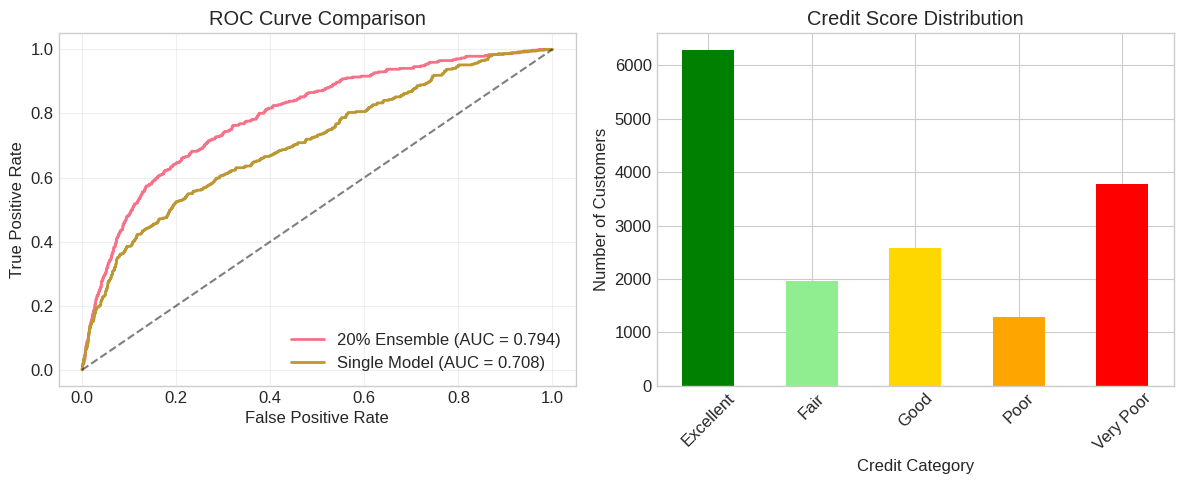

In [19]:
print_section('FINAL PERFORMANCE VISUALIZATION')

# ROC Comparison

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_proba_ensemble)
fpr_single, tpr_single, _ = roc_curve(y_test, y_proba_single)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_ensemble, tpr_ensemble, label = f'20% Ensemble (AUC = {auc_ensemble:.3f})', linewidth = 2)
plt.plot(fpr_single, tpr_single, label = f'Single Model (AUC = {auc_single:.3f})', linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha = 0.3)

# Credit Score Distribution

plt.subplot(1, 2, 2)
score_counts = results_df['Score_Category'].value_counts().sort_index()
colors = ['green', 'lightgreen', 'gold', 'orange', 'red']
score_counts.plot(kind = 'bar', color = colors)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.savefig(OUT_DIR / 'final_performance_comparison.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# FINAL SUMMARY

In [ ]:
print_section("PROJECT SUMMARY & BUSINESS IMPACT")

print(" 20% SUBSET ENSEMBLE STRATEGY - COMPLETED SUCCESSFULLY!")
print("\n KEY ACHIEVEMENTS:")
print(f'    AUC Improvement: {improvement_auc:+.2f}% over single model')
print(f'    Training Efficiency: {SUBSET_RATIO:.0%} data per model ({len(trained_ensemble)} models)')
print(f'    Model Diversity: {len(set(m['model_name'] for m in trained_ensemble))} unique architectures')
print(f'    Business Optimization: ${best_cost:,.0f} minimum cost')
print(f'    Credit Scoring: {len(results_df):,} customers scored')

print(f'\n BUSINESS VALUE:')
print(f'   Better risk prediction: {improvement_auc:+.2f}% AUC improvement')
print(f'   Faster training: 5x speedup per model')
print(f'   Cost savings: Optimized decision threshold')
print(f'   Scalable: Easy to add new models')

print(f'\n DELIVERABLES:')
print(f'    {len(list(eda_dir.glob('*.png')))} EDA visualization plots')
print(f'    Trained ensemble model with {len(trained_ensemble)} diverse models')
print(f'    Performance comparison reports')
print(f'    Credit scores for {len(results_df):,} customers')
print(f'    Comprehensive documentation')

print(f'\n The 20% subset strategy successfully demonstrates that')
print(f'   maximum diversity can compensate for reduced data,')
print(f'   delivering superior performance with efficient training!')